In [79]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.metrics import Accuracy, AUC, Precision, Recall
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.resnet_v2 import preprocess_input
%matplotlib inline

In [80]:
# Image size (width, height, dimensionality = 3)
target_size = (224,224, 3)

# Total classes for classification in the dataset
total_classes = 17

# Batch size
batch_size = 16

# Dataset directory
path_to_dataset = "../dataset"

In [81]:
conv_base_res_net152_V2 = ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=target_size,
    pooling="avg"
)

In [82]:
# Freeze the conv_base_res_net152_V2 layers
conv_base_res_net152_V2.trainable = False

# Un freeze the Batch Normalization layers
for layer in conv_base_res_net152_V2.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [83]:
x = conv_base_res_net152_V2.output

x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(total_classes, activation="softmax")(x)

# Generate the model
model = Model(inputs = conv_base_res_net152_V2.input, outputs = x)

In [84]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [85]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_acc",
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [86]:
for layer in model.layers:
    layer.trainable = True

adam_fine = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [87]:
model.compile(optimizer=adam_fine, loss="categorical_crossentropy", metrics=['acc'])

In [88]:
data_generator=ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.20)

In [89]:
train_generator = data_generator.flow_from_directory(
    path_to_dataset,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = data_generator.flow_from_directory(
    path_to_dataset,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3539 images belonging to 17 classes.
Found 876 images belonging to 17 classes.


In [90]:
checkpoint_filepath = "/best model"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True
)

In [91]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[learning_rate_reduction, model_checkpoint_callback]
)

Epoch 1/30
222/222 [==============================] - 1143s 5s/step - loss: 1.3155 - acc: 0.5880 - val_loss: 0.8773 - val_acc: 0.7363 - lr: 5.0000e-05
Epoch 2/30
222/222 [==============================] - 1125s 5s/step - loss: 0.3724 - acc: 0.8864 - val_loss: 0.5567 - val_acc: 0.8322 - lr: 5.0000e-05
Epoch 3/30
222/222 [==============================] - 1111s 5s/step - loss: 0.1704 - acc: 0.9520 - val_loss: 0.4635 - val_acc: 0.8710 - lr: 5.0000e-05
Epoch 4/30
222/222 [==============================] - 1107s 5s/step - loss: 0.1288 - acc: 0.9627 - val_loss: 0.5770 - val_acc: 0.8550 - lr: 5.0000e-05
Epoch 5/30
222/222 [==============================] - 1099s 5s/step - loss: 0.0943 - acc: 0.9712 - val_loss: 0.3784 - val_acc: 0.9018 - lr: 5.0000e-05
Epoch 6/30
222/222 [==============================] - 1108s 5s/step - loss: 0.0777 - acc: 0.9751 - val_loss: 0.4305 - val_acc: 0.8893 - lr: 5.0000e-05
Epoch 7/30
222/222 [==============================] - 1111s 5s/step - loss: 0.0786 - acc: 0.97

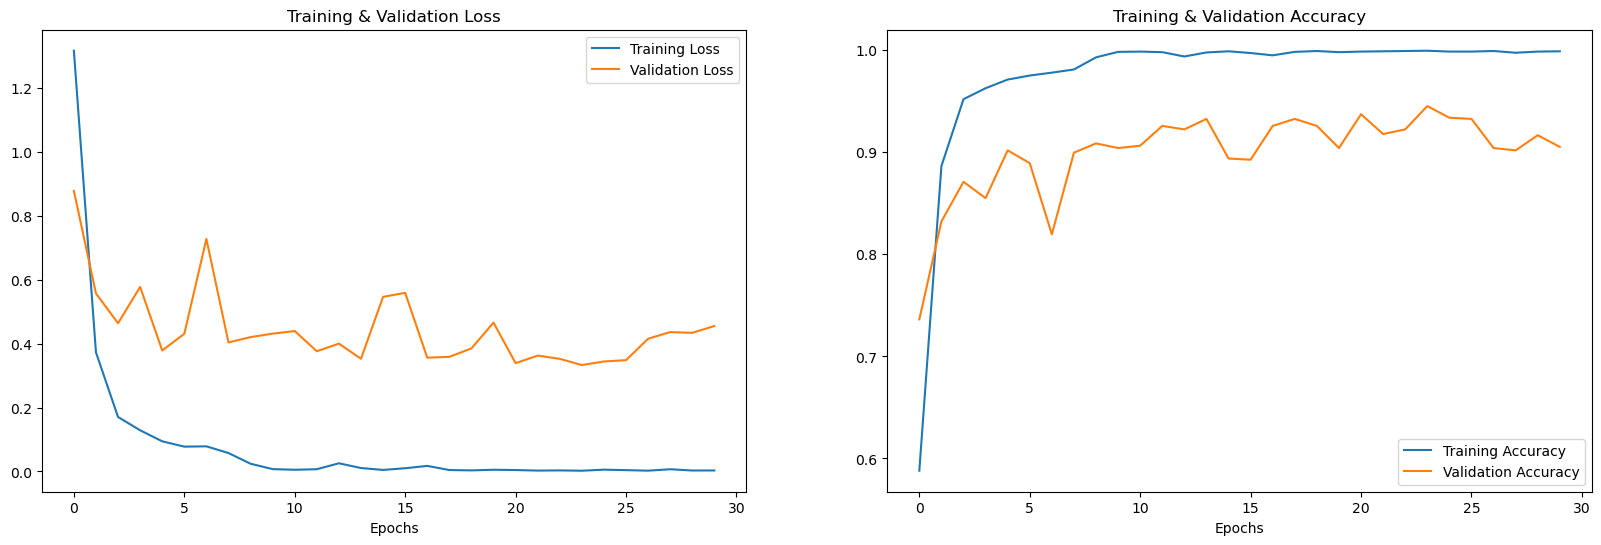

In [95]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()